
### input:

Text Article

### output:
[out1%, out2%]
- out1: % of chance this news is fake
- out2: % of chance this news is true


In [4]:
# import dataset
import requests
filename = 'fakenews.zip'
token = '48eb51ebd68f3d2a99b72ec339b32756402007c5'
url = 'https://gitarero.ecam.fr/api/v1/repos/etienne.vienot/machine_learning/raw/' + filename +'?token=' + token
r = requests.get(url)
open(filename , 'wb').write(r.content)

88078939

In [5]:
!unzip '/content/fakenews.zip' -d "/content/."

Archive:  /content/fakenews.zip
replace /content/./DataSet_Misinfo_FAKE.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [6]:
# prompt: open /content/DataSet_Misinfo_FAKE.csv and /content/DataSet_Misinfo_TRUE.csv and display some lines

import pandas as pd
df_fake = pd.read_csv('/content/DataSet_Misinfo_FAKE.csv')
df_true = pd.read_csv('/content/DataSet_Misinfo_TRUE.csv')

df_fake.head()
df_true.head()



,Unnamed: 0,text
0,0,The head of a conservative Republican faction ...
1,1,Transgender people will be allowed for the fir...
2,2,The special counsel investigation of links bet...
3,3,Trump campaign adviser George Papadopoulos tol...
4,4,President Donald Trump called on the U.S. Post...


In [7]:
#Import libraries
import tensorflow as tf #TensorFlow
import tensorflow_datasets as tfds #Datasets
import numpy as np #linear algebra
import matplotlib.pyplot as plt #Data visualization
import random

#Make sure TensorFlow is version 2.0 or higher
print('TensorFlow Version:', tf.__version__)

TensorFlow Version: 2.19.0


In [8]:
# Create the full dataset with the labels
dataset_text = df_fake['text'].tolist() + df_true['text'].tolist()
dataset_text = [str(text) if isinstance(text, str) else "" for text in dataset_text]
dataset_labels = [0] * len(df_fake) + [1] * len(df_true)

# Shuffle dataset while keeping labels in order
c = list(zip(dataset_text, dataset_labels))
random.shuffle(c)
dataset_text, dataset_labels = zip(*c)

# Convert tuples back to lists
dataset_text = list(dataset_text)
dataset_labels = list(dataset_labels)

# Remove articles with a wordcount smaller than x
min_wordcount = 10
for i in range(len(dataset_text) - 1, -1, -1):
    if len(str(dataset_text[i]).split()) < min_wordcount:
        dataset_text.pop(i)
        dataset_labels.pop(i)


In [9]:
#statistics on the dataset:
print(f"Number of articles: {len(dataset_text)}")
print(f"Number of fake articles: {len(df_fake)}")
print(f"Number of true articles: {len(df_true)}")
min_wordcount = min([len(str(text).split()) for text in dataset_text])
smallest_article = [str(text).split() for text in dataset_text if len(str(text).split()) == min_wordcount]
max_wordcount = max([len(str(text).split()) for text in dataset_text])
largest_article = [str(text).split() for text in dataset_text if len(str(text).split()) == max_wordcount]
avg_wordcount = sum([len(str(text).split()) for text in dataset_text]) / len(dataset_text)
print(f"minimum article length: {min_wordcount} words")
print(f"maximum article length: {max_wordcount} words")
print(f"average article length: {round(avg_wordcount)} words")
smallest_article = " ".join(smallest_article[0])
largest_article = " ".join(largest_article[0])
print(f"smallest article: {smallest_article}")
print(f"largest article: {largest_article}")
total_wordcount = sum([len(str(text).split()) for text in dataset_text])
print(f"total wordcount: {total_wordcount}")

Number of articles: 77763
Number of fake articles: 43642
Number of true articles: 34975
minimum article length: 10 words
maximum article length: 24234 words
average article length: 485 words
smallest article: And for the last two weeks, Gold is "naturally", unchanged.
largest article: The Hard Working American vs. The Government Parasite By Michael Snyder, on April 10th, 2012 Which lifestyle choice produces better results – being a hard working American or being a government parasite? Actually, when you look at the cold, hard numbers they may just surprise you. In America today, we deeply penalize hard work and we greatly reward government dependence. If you live in a very liberal area of the country and you know how to game the system, it is entirely possible to live a comfortable existence without ever working too much at all. In fact, there are some Americans that have been living off of “government benefits” for decades. Many of these people actually plan their lives around doing e

In [10]:


#Create empty lists to hold our training and test text and labels
train_text = []
train_labels = []
test_text = []
test_labels = []

NUMBER_WORDS_TAKEN = 400

#split the fake and true news into training and testing dataset, and shuffle them
def split_dataset(ratio_train_total = 0.7):
  size_test = round(len(dataset_text) * ratio_train_total)
  size_train = len(dataset_text) - size_test
  train_text = [str(text).split()[:NUMBER_WORDS_TAKEN] for text in dataset_text[:size_train]]
  train_labels = dataset_labels[:size_train]
  test_text = [str(text).split()[:NUMBER_WORDS_TAKEN] for text in dataset_text[size_train:]]
  test_labels = dataset_labels[size_train:]
  return train_text, train_labels, test_text, test_labels

train_text, train_labels, test_text, test_labels = split_dataset()

# DEBUG: shows the 5 first values of the training dataset, with their corresponding values
if True:
  #prints a samples from the training set
  print("FIRST 5 SAMPLES OF TRAINING DATA")
  print("============================================================")
  for i in range(5):
      review = "Real news" if train_labels[i] == 1 else "Fake news"
      print("News type:", review)
      print("News text:", " ".join(train_text[i]))
      print("============================================================")

FIRST 5 SAMPLES OF TRAINING DATA
News type: Real news
News text: In perhaps the clearest signal yet that the era of the solo celebrity architect is behind us, three friends who hung out a shingle in their Catalonian hometown, Olot, Spain, 30 years ago and never left or parted ways have won their profession’s highest honor: the Pritzker Prize. Rafael Aranda, Carme Pigem and Ramon Vilalta on Wednesday became the first team of three to be selected for the prize, which will be awarded in Tokyo on May 20. “Their intensely collaborative way of working together, where the creative process, commitment to vision and all responsibilities are shared equally, led to the selection of the three individuals for this year’s award,” Thomas J. Pritzker, the chairman of Hyatt Foundation, which sponsors the award, said in a statement, adding, “Mr. Aranda, Ms. Pigem and Mr. Vilalta have had an impact on the discipline far beyond their immediate area. ” Ms. Pigem, who spoke for the group because her English

In [11]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#Creates and fits a TensorFlow Tokenizer
tokenizer = Tokenizer(num_words=20000, oov_token='<OOV>')
tokenizer.fit_on_texts(train_text)

#Creates sequences of numeric representations of words
training_sequences = tokenizer.texts_to_sequences(train_text)
#pads sequences so they all have the same length
training_sequences = pad_sequences(training_sequences, maxlen=NUMBER_WORDS_TAKEN)

#Process test data in the same way for later evaluation
testing_sequences = tokenizer.texts_to_sequences(test_text)
testing_sequences = pad_sequences(testing_sequences, maxlen=NUMBER_WORDS_TAKEN)


#prints a sample of the new sequences
print('PROCESSED TEXT DATA')
print('=========================')
for i in range(5):
    print(training_sequences[i], '\n')

PROCESSED TEXT DATA
[    7  1051     2     1  3906   364     8     2  3994     4     2 16357
  4401 12805    10   403  1516   195  1115    31  7247    60     5     1
     7    38     1     1     1  8517   955   147   896     6   201   254
    44     1  1344    22   362    38     1  1635     1     2 17264 19100
 14334     1     1     1     6     1     1     9   298   707     2    96
   418     4   195     3    23  6161    11     2 16806    46    37    23
  4579     7  7550     9   122  6798 16807 19821 17265   171     4   337
  3605   127     2  5491  3407  2160     3  2831     6    58  8301    25
  1517     1   466     3     2  5287     4     2   195  1345    11    29
  2194     1  2474   533     1     2   655     4     1  3238    46  9506
     2 12806    27     7     5  1906  8302  8623     1   513     1     6
    91     1    22    40    30  1331     9     2  9507   316  1242    38
  1958  3889   118   513     1    31   753    11     2   192    84    47
  2621    10     1    27     7 

In [12]:
from tensorflow.keras.callbacks import Callback

threshold = 0.99

class CustomCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') > threshold:
            print(f"Accuracy over {threshold}%... Stopping training")
            self.model.stop_training = True

my_callback = CustomCallback()

In [13]:
from tensorflow.keras.callbacks import LearningRateScheduler

#creates a function that updates the learning rate based on the epoch number
def scheduler(epoch, lr):
    if epoch < 2:
        return 0.01
    else:
        return lr * 0.99

lr_scheduler = LearningRateScheduler(scheduler)

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout, Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import Adam

#input dimensions is equal to number of words tokenized (defined above)
input_dim = 20000
# input length will be the length of our padded sequences
input_length = NUMBER_WORDS_TAKEN

#SECOND NETWORK

#defines a text classifier model
model2 = Sequential([
    Embedding(input_dim=input_dim, output_dim=64),
    Dropout(0.4),
    #TESTS, not actually used in the final model
    #Conv1D(filters=64, kernel_size=5, activation='relu'),  # First Convolutional layer
    #MaxPooling1D(pool_size=2),  # Max Pooling layer
    #Conv1D(filters=128, kernel_size=3, activation='relu'),  # Second Convolutional layer
    Bidirectional(LSTM(64)),
    Dropout(0.6),
    Dense(512, activation='relu'),
    Dropout(0.4),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

model2.compile(
    loss='binary_crossentropy',
    optimizer=Adam(),
    metrics=['accuracy']
)


In [15]:
#trains the model ... may take a few minutes
history = model2.fit(
    np.array(training_sequences), #must convert to numpy array before sending to model
    np.array(train_labels),       #must convert to numpy array before sending to model
    epochs=100,
    validation_split=0.2,
    batch_size=256,
    callbacks=[my_callback, lr_scheduler],
    verbose=2)

Epoch 1/100
73/73 - 12s - 163ms/step - accuracy: 0.7939 - loss: 0.4585 - val_accuracy: 0.8980 - val_loss: 0.2623 - learning_rate: 0.0100
Epoch 2/100
73/73 - 3s - 46ms/step - accuracy: 0.8881 - loss: 0.2819 - val_accuracy: 0.8318 - val_loss: 0.3642 - learning_rate: 0.0100
Epoch 3/100
73/73 - 3s - 47ms/step - accuracy: 0.9570 - loss: 0.1301 - val_accuracy: 0.9421 - val_loss: 0.1680 - learning_rate: 0.0099
Epoch 4/100
73/73 - 5s - 68ms/step - accuracy: 0.9884 - loss: 0.0390 - val_accuracy: 0.9533 - val_loss: 0.2045 - learning_rate: 0.0098
Epoch 5/100
Accuracy over 0.99%... Stopping training
73/73 - 3s - 46ms/step - accuracy: 0.9949 - loss: 0.0179 - val_accuracy: 0.9524 - val_loss: 0.2260 - learning_rate: 0.0097


In [16]:
model2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 400, 64)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 400, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,237,829 (16.17 MB)

 Trainable params: 1,412,609 (5.39 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,825,220 (10.78 MB)

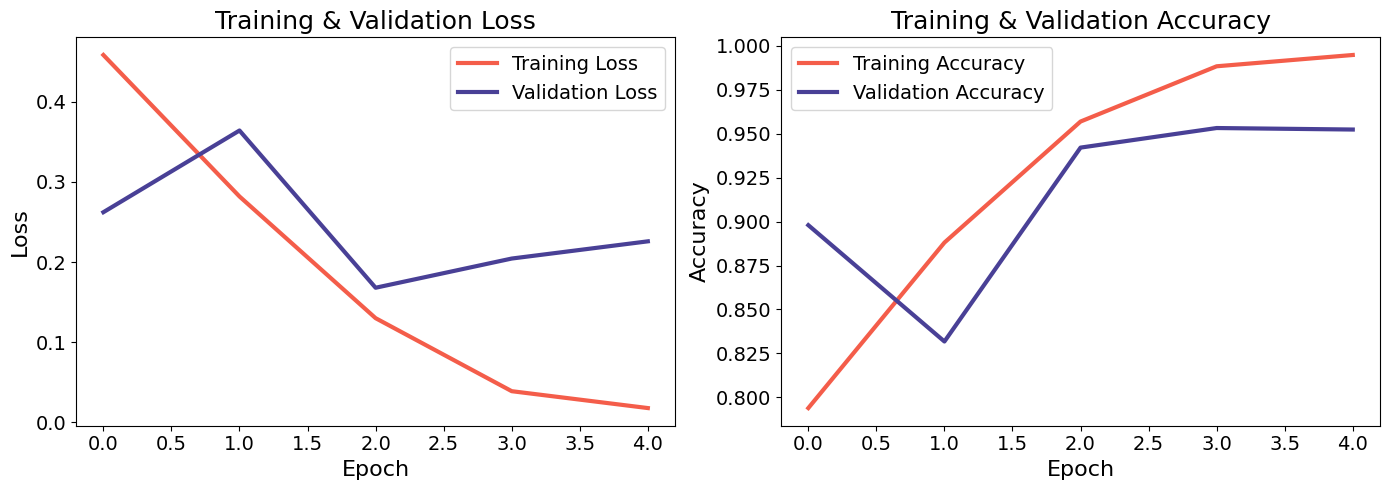

In [23]:
#Plots history of model training
plt.rcParams["figure.figsize"] = (14,5)
fig, axs = plt.subplots(1, 2)

# Custom colors
train_color = "#f45d4a"   # orange-red
val_color   = "#494096"   # deep purple

# ---- LOSS ----
axs[0].plot(history.history['loss'], label='Training Loss', color=train_color, linewidth=3)
axs[0].plot(history.history['val_loss'], label='Validation Loss', color=val_color, linewidth=3)
axs[0].set_xlabel('Epoch', fontsize=16)
axs[0].set_ylabel('Loss', fontsize=16)
axs[0].set_title('Training & Validation Loss', fontsize=18)
axs[0].tick_params(axis='both', labelsize=14)
axs[0].legend(fontsize=14)

# ---- ACCURACY ----
axs[1].plot(history.history['accuracy'], label='Training Accuracy', color=train_color, linewidth=3)
axs[1].plot(history.history['val_accuracy'], label='Validation Accuracy', color=val_color, linewidth=3)
axs[1].set_xlabel('Epoch', fontsize=16)
axs[1].set_ylabel('Accuracy', fontsize=16)
axs[1].set_title('Training & Validation Accuracy', fontsize=18)
axs[1].tick_params(axis='both', labelsize=14)
axs[1].legend(fontsize=14)

plt.tight_layout()
plt.show()

In [18]:
#Measures models preformance on the testing data
evaluation = model2.evaluate(
    np.array(testing_sequences), #must convert to numpy array before sending to model
    np.array(test_labels),       #must convert to numpy array before sending to model
    batch_size=256,
    verbose=0
)

#Prints accuracy of model on testing data
print("MODEL ACCURACY ON TEST DATA: {}%".format(round(evaluation[1], 3) * 100))

MODEL ACCURACY ON TEST DATA: 95.8%


In [19]:
# user input to test the model with data outside from the dataset

#Lets see what the model thinks of a new review (keep in mind the review will be cut off after 20 words)
#Enter your article here
NEW_REVIEW = input("Copy paste an article here:" )

#Process the new article the same way the test text was processed
new_review_sequence = tokenizer.texts_to_sequences([NEW_REVIEW])
new_review_sequence = pad_sequences(new_review_sequence, maxlen=NUMBER_WORDS_TAKEN)

#sends new article to be predicted by the model
new_review_prediction_float = model2.predict(np.array(new_review_sequence))[0][0]
new_review_prediction = round(new_review_prediction_float)
sentiment = "FAKE NEWS" if new_review_prediction == 0 else "REAL NEWS"

#displays what the model thinks the sentiment of the article was
print(f"article: '{NEW_REVIEW}'")
print(f"MODEL PREDICTED TRUENESS: {sentiment}, (Article is detected as {round(new_review_prediction_float*100)}% true)")


Copy paste an article here:The video published in 2014 claimed that Michael Jackson is still alive and escaped to LA. His mysterious death is still raising discussion between those who believe he is alive and those who do not, in a series of comments under the video. The respectable music magazine New Musical Express claims that it is user BeLiEve who posts regular videos claiming Jackson’s death was a hoax
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
article: 'The video published in 2014 claimed that Michael Jackson is still alive and escaped to LA. His mysterious death is still raising discussion between those who believe he is alive and those who do not, in a series of comments under the video. The respectable music magazine New Musical Express claims that it is user BeLiEve who posts regular videos claiming Jackson’s death was a hoax'
MODEL PREDICTED TRUENESS: FAKE NEWS, (Article is detected as 0% true)
